# Plasma-driven permeation

This validation case is a plasma-driven permeation performed at INL in 1985 {cite}`anderl_tritium_1986`.
Deuterium ions at 3 keV was implanted in a 0.5 mm thick sample of 316 stainless steel variant called primary candidate alloy (PCA).

The ion beam was turned on and off repeatedly and it is estimated that the implanted flux is $4.9 \times 10^{19} \ \mathrm{D \ m^{-2} s^{-1}}$:

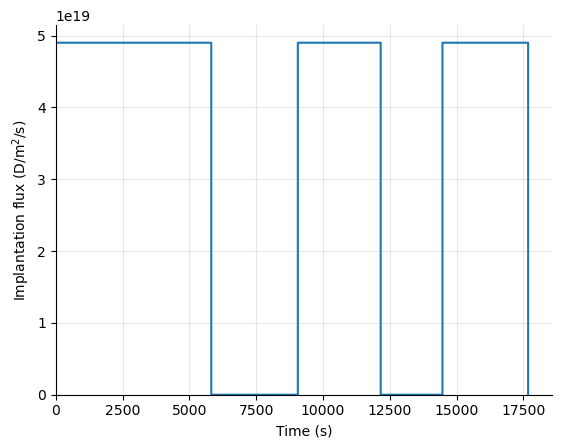

In [7]:
import matplotlib.pyplot as plt

time = [0.0, 5820.0, 5820.1, 9060.0, 9060.1, 12160.0, 12160.1, 14472.0, 14472.1, 17678.0, 17678.1, 1.0e10]  # taken from the TMAP7 report
flux = [4.9e19, 4.9e19, 0.0, 0.0, 4.9e19, 4.9e19, 0.0, 0.0, 4.9e19, 4.9e19, 0.0, 0.0]

plt.plot(time[:-1], flux[:-1])
plt.xlabel('Time (s)')
plt.ylabel('Implantation flux (D/m$^2$/s)')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(alpha=0.3)
plt.show()


SRIM calculations performed in the TMAP4 {cite}`longhurst_verification_1992` and TMAP7 {cite}`ambrosek_verification_2008` V&V reports showed that at this energy, deuterium ions were implanted at $11 \ \mathrm{nm} \pm 5.4 \ \mathrm{nm}$.

A normal distribution was therefore used with a mean at $12 \ \mathrm{nm}$ and a standard deviation of $2.3 \ \mathrm{nm}$.

```{note}
These normal distribution parameters were obtained by comparing the TMAP7 source distribution. See below.
```


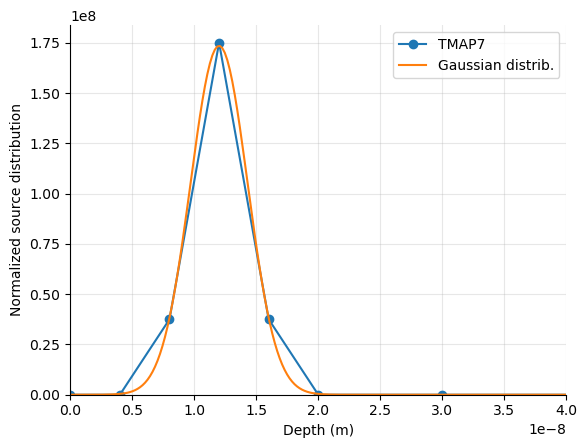

In [2]:
import numpy as np

deltax = [
    0.0,
    5 * [4.0e-9],
    1.0e-8,
    1.0e-7,
    1.0e-6,
    1.0e-5,
    10 * [4.88e-5],
]  # taken from the TMAP7 report
x = 0
x_points = []
for i in deltax:
    if isinstance(i, list):
        for j in i:
            x += j
            x_points.append(x)
    else:
        x += i
        x_points.append(x)

source_distrib_at_nodes = [
    3 * [0.0],
    0.15,
    0.7,
    0.15,
    15 * [0.0],
]  # taken from the TMAP7 report
source_distribution = []
for i in source_distrib_at_nodes:
    if isinstance(i, list):
        for j in i:
            source_distribution.append(j)
    else:
        source_distribution.append(i)

width = 2.3e-9
mean = 12e-9
x_festim = np.linspace(0, 40e-9, 200)
festim_source_distrib = (
    1 / (width * (2 * np.pi) ** 0.5) * np.exp(-0.5 * ((x_festim - mean) / width) ** 2)
)


area = np.trapz(source_distribution[1:], x_points)
source_distribution = np.array(source_distribution) / area

plt.plot(x_points, source_distribution[1:], label="TMAP7", marker="o")
plt.plot(x_festim, festim_source_distrib, label="Gaussian distrib.")

plt.xlim(0, 40e-9)
plt.ylim(bottom=0)
plt.xlabel("Depth (m)")
plt.ylabel("Normalized source distribution")
plt.legend()
plt.gca().spines[["top", "right"]].set_visible(False)
plt.grid(alpha=0.3)
plt.show()

The diffusion coefficient was taken as $D = 3 \times 10^{-10}$.

2nd order recombination fluxes were set on the boundaries.
On $x=0$ (the beam-facing surface), the recombination coefficient ($\mathrm{m^4 \ atom^{-1} \ s^{-1}}$) was $K_\mathrm{r} = 7.0 \times 10^{-27} \ \left( 1 - 0.999997 \ \exp{-1.2\times 10^{-4} \ t} \right) $.
The time dependent term was added to mimick the surface cleanup: as the sample is exposed the recombination coefficient increases and approches $7.0 \times 10^{-27} \ \mathrm{m^4 \ atom^{-1} \ s^{-1}}$.

On $x = 0.5 \ \mathrm{mm}$ (the non-exposed surface), the recombination coefficient was taken as $K_\mathrm{r} = 2.0 \times 10^{-31} \ \mathrm{m^4 \ atom^{-1} \ s^{-1}}$.


```{note}
This parametrisation was taken from the TMAP7 V&V report {cite}`ambrosek_verification_2008`.
The authors originally added dissociation fluxes that would model the impact of low pressures in the upstream and downstream volumes but it turns out to be negligible.
```

## FESTIM code

In [3]:
import festim as F
import sympy as sp

my_model = F.Simulation()

vertices = np.concatenate(
    [
        np.linspace(0, 20e-9, 50),
        np.linspace(20e-9, 3e-6, 500),
        np.linspace(3e-6, 0.5e-3, 500),
    ]
)

my_model.mesh = F.MeshFromVertices(vertices)

my_model.materials = F.Material(id=1, D_0=3e-10, E_D=0)

my_model.boundary_conditions = [
    F.RecombinationFlux(
        Kr_0=7.0e-27 * (1.0 - 0.999997 * sp.exp(-1.2e-4 * F.t)),
        E_Kr=0,
        surfaces=[1],
        order=2,
    ),
    F.RecombinationFlux(Kr_0=2.0e-31, E_Kr=0, surfaces=[2], order=2),
]

flux = sp.Piecewise(
    (4.9e19, F.t < 5820),
    (0, F.t < 9060),
    (4.9e19, F.t < 12160),
    (0, F.t < 14472),
    (4.9e19, F.t < 17678),
    (0, F.t < 1e10),
    (0, True),
)
my_model.sources = [
    F.ImplantationFlux(flux=flux, imp_depth=12e-9, width=2.3e-9, volume=1)
]

my_model.T = F.Temperature(500)  # ignored here

left_flux = F.SurfaceFlux(surface=1, field="solute")
right_flux = F.SurfaceFlux(surface=2, field="solute")
my_model.exports = [
    F.DerivedQuantities([left_flux, right_flux]),
    F.XDMFExport(field="solute", checkpoint=False),
]

my_model.settings = F.Settings(
    absolute_tolerance=1e9,
    relative_tolerance=1e-10,
    final_time=21000,
)

my_model.dt = F.Stepsize(initial_value=20)

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        2.1e+04 s    Ellapsed time so far: 5.2 s


## Comparison with experimental data

The results produced by FESTIM are in good agreement with the experimental data.

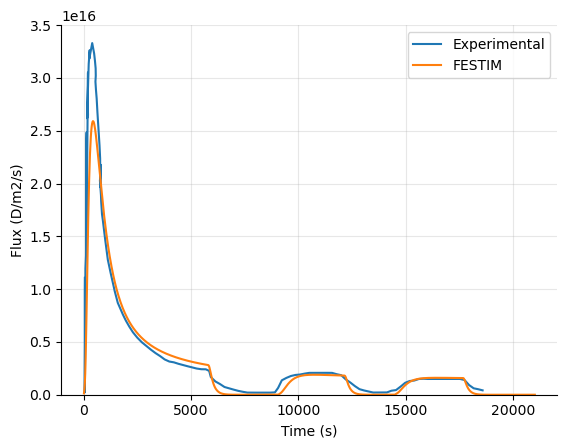

In [6]:
experimental_data = np.genfromtxt("plasma-driven-permeation-experiment.csv", delimiter=",")
experimental_t = experimental_data[:, 0]
experimental_flux = experimental_data[:, 1]

time = left_flux.t
flux_right_values = np.array(right_flux.data)


plt.plot(experimental_t, experimental_flux, label="Experimental")
plt.plot(time, -flux_right_values, label="FESTIM")

plt.ylabel("Flux (D/m2/s)")
plt.xlabel("Time (s)")
plt.ylim(0, 3.5e16)
plt.legend()
plt.gca().spines[["top", "right"]].set_visible(False)
plt.grid(alpha=0.3)
plt.show()

```{note}
The experimental data was taken from Figure 27 of the TMAP7 V&V report {cite}`ambrosek_verification_2008`
```

```{warning}
There is a inconsistence between the TMAP4 and TMAP7 V&V reports. Both show the same values for the experimental curve, but TMAP4 gives it as $\mathrm{D \ m^{-2} \ s^{-1}}$ whereas TMAP7 gives it as $\mathrm{D \ s^{-1}}$.
It appears this is likely to be a labelling mistake in the TMAP7 report.
```